In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn

array([4])

### Load and Display Images

In [5]:
salinas = np.load('salinas.npy', allow_pickle=True)
salinas_gt = np.load('salinas_gt.npy', allow_pickle=True)
print(salinas.shape)
print(salinas_gt.shape)

(512, 217, 204)
(512, 217)


In [6]:
indiana_pines = np.load('indianapines.npy', allow_pickle=True)
indiana_pines_gt = np.load('indianapines_gt.npy', allow_pickle=True)
print(indiana_pines.shape)
print(indiana_pines_gt.shape)

(145, 145, 200)
(145, 145)


In [7]:
def plot_RGB(image):
    imageRGB = np.array(image[:, :, [30, 15, 2]], dtype=float)

    pmin,pmax = np.percentile(imageRGB, (1,99), axis=(0,1))
    print(pmin, pmax)
    imageRGB_pimped = imageRGB.copy()

    for i in range(pmin.size):
        imageRGB_pimped[:,:,i] = (imageRGB[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])

    imageRGB_pimped[imageRGB_pimped < 0] = 0
    imageRGB_pimped[imageRGB_pimped > 1] = 1

    plt.figure(figsize=(5,5))
    plt.imshow(imageRGB_pimped)
    plt.show()

[ 600. 1045.  474.] [3747. 3107.  927.]


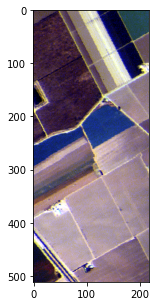

In [8]:
plot_RGB(salinas)

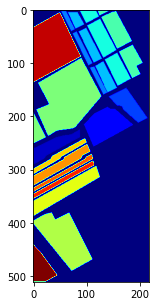

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')

[2353. 2761. 3833.] [5442.   6051.76 4946.  ]


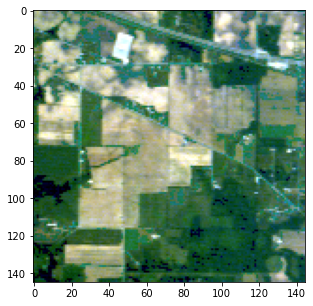

In [10]:
plot_RGB(indiana_pines)

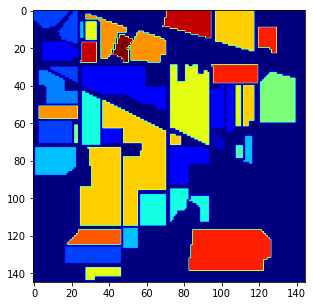

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')

### PCA

In [12]:
def flatten_image(X):
    return X.reshape((-1, X.shape[-1]))

X1 = flatten_image(salinas)
Y1 = salinas_gt.flatten()
print(X1.shape)
print(Y1.shape)

X2 = flatten_image(indiana_pines)
Y2 = indiana_pines_gt.flatten()
X2 = X2[Y2 != 0]
Y2 = Y2[Y2 != 0] - 1
print(X2.shape)
print(Y2.shape)

(111104, 204)
(111104,)
(10249, 200)
(10249,)


In [13]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=1)
print(X1_train.shape)
print(Y1_train.shape)


(88883, 204)
(88883,)


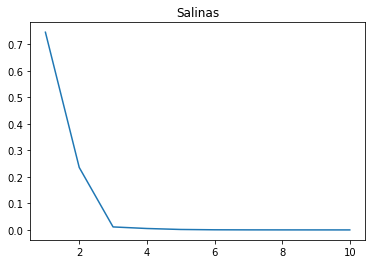

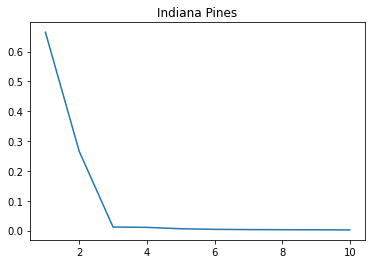

In [15]:
from sklearn import decomposition

def pca_components(X, name):
    pca = decomposition.PCA(n_components=10)
    pca.fit(X)

    plt.plot(np.arange(1, 11), pca.explained_variance_ratio_)
    plt.title(name)
    plt.show()

pca_components(X1, "Salinas")
pca_components(X2, "Indiana Pines")

Variance greater than 0.999: 3


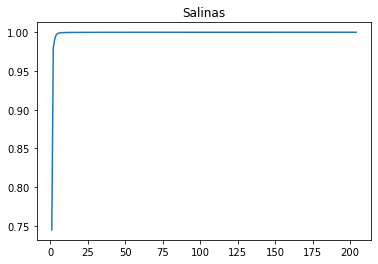

Variance greater than 0.999: 34


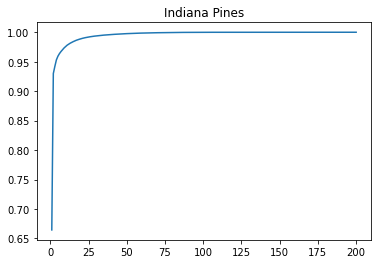

In [19]:
def pca_components_cumsum(X, name):
    pca = decomposition.PCA()
    pca.fit(X)

    variances = np.cumsum(pca.explained_variance_ratio_)
    print("Variance greater than 0.999:", np.argmax(variances > 0.995))

    plt.plot(np.arange(1, X.shape[-1] + 1), variances)
    plt.title(name)
    plt.show()

pca_components_cumsum(X1, "Salinas")
pca_components_cumsum(X2, "Indiana Pines")

In [18]:
pca1 = decomposition.PCA(n_components=20)
pca1.fit(X1)
print(pca1.components_.shape)

X1_pca = pca1.transform(X1)
print(X1_pca.shape)

(20, 204)
(111104, 20)


In [13]:
pca2 = decomposition.PCA(n_components=68)
pca2.fit(X2)
print(pca2.components_.shape)

X2_pca = pca2.transform(X2)
print(X2_pca.shape)

(68, 200)
(21025, 68)


### Classifier

In [12]:
from sklearn.utils import class_weight
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [51]:
def class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(zip(np.arange(17), class_weights))

    print(class_weights)

    return class_weights

class_weights1 = class_weights(Y1)
class_weights2 = class_weights(Y2)

{0: 0.11470872157551042, 1: 3.2531256405001026, 2: 1.7540336585519876, 3: 3.3074541557513695, 4: 4.68832812895603, 5: 2.4404516100689717, 6: 1.650803084557895, 7: 1.826076952155548, 8: 0.5798535544108514, 9: 1.0536078368152033, 10: 1.9937551591716614, 11: 6.11940956157744, 12: 3.3915565188192556, 13: 7.134857436424351, 14: 6.107971412864211, 15: 0.8992197869791835, 16: 3.6167844005338714}
{0: 0.11477029564609809, 1: 26.88618925831202, 2: 0.8660817268083704, 3: 1.490077958894401, 4: 5.218416480516257, 5: 2.5605894531725735, 6: 1.6941982272361, 7: 44.17016806722689, 8: 2.5873738616785626, 9: 61.838235294117645, 10: 1.27239167271847, 11: 0.5037738109500419, 12: 2.08560658664815, 13: 6.032998565279771, 14: 0.9776796093931643, 15: 3.2040536421822616, 16: 13.29854522454143}


In [14]:
clf = SGDClassifier(shuffle=True, early_stopping=True, class_weight=class_weights1, random_state=1)

### One vs rest classifier

In [157]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline, Pipeline

In [92]:
clf = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=100), n_jobs=4)

In [27]:
clf_pipeline = OneVsRestClassifier(LinearSVC(random_state=1, max_iter=1000), n_jobs=4)
clf = make_pipeline(StandardScaler(), clf_pipeline)

### One vs one classifier


In [ ]:
from sklearn.multiclass import OneVsOneClassifier

In [33]:
clf_pipeline = OneVsOneClassifier(LinearSVC(random_state=1, max_iter=1000), n_jobs=6)
clf = make_pipeline(StandardScaler(), clf_pipeline)

### Custom Classifier

In [187]:
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [243]:
class MyClassifier(ClassifierMixin):
    def __init__(self, clf, class_weights=None):
        self.clf_ = clf
        self.class_weights_ = class_weights
    
    def fit(self, X, y):
        self.label_binarizer_ = LabelBinarizer(sparse_output=False)
        Y = self.label_binarizer_.fit_transform(y)
        columns = Y.T
        self.estimators_ = []

        for i, y_bin in enumerate(columns[1:]):
            print(i)
            clf_copy = clone(self.clf_)
            if self.class_weights_ is not None:
                clf_copy.set_params(class_weight={0: 1, 1: self.class_weights_[i + 1]})
            self.estimators_.append(clf_copy.fit(X, y_bin))
            
#         self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)(
#             self.estimator, X, column, classes=[
#                 "not %s" % self.label_binarizer_.classes_[i],
#                 self.label_binarizer_.classes_[i]])
#             for i, column in enumerate(columns))
        
    def predict(self, X):
        maxima = np.full(X.shape[0], -np.inf)
        argmaxima = np.zeros(X.shape[0], dtype=int)

        for i, e in enumerate(self.estimators_):
            proba_y = e.predict_proba(X)[:,1]
            np.maximum(maxima, proba_y, out=maxima)
            argmaxima[maxima == proba_y] = i + 1
            
        argmaxima[maxima < 0.5] = 0
        return argmaxima

In [245]:
clf_pipeline = MyClassifier(DecisionTreeClassifier(random_state=1), class_weights1)
clf = make_pipeline(StandardScaler(), clf_pipeline)

In [20]:
def reconstruct_image(ground_truth, prediction):
    reconstructed_img = ground_truth.copy()
    
    print(reconstructed_img.shape)
    original_img = ground_truth.flatten()
    indexes = np.where(original_img != 0)[0]
    index_predict = 0
    reconstructed_img[idx] = prediction
    return np.reshape(reconstructed_img, ground_truth.shape)

### Fit

In [246]:
clf.fit(X1_train, Y1_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('myclassifier',
                 <__main__.MyClassifier object at 0x7fa1fb85cb20>)])

In [234]:
clf.fit(X2, Y2)

0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

### Testing

In [58]:
from sklearn.metrics import plot_confusion_matrix, classification_report

0.8820485126681967
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     11252
           1       0.89      0.85      0.87       414
           2       0.94      0.92      0.93       752
           3       0.84      0.82      0.83       394
           4       0.84      0.85      0.85       268
           5       0.90      0.87      0.88       553
           6       0.93      0.92      0.92       792
           7       0.94      0.95      0.95       709
           8       0.85      0.69      0.76      2287
           9       0.92      0.92      0.92      1236
          10       0.91      0.89      0.90       664
          11       0.84      0.84      0.84       197
          12       0.91      0.88      0.89       401
          13       0.83      0.86      0.85       180
          14       0.85      0.84      0.84       230
          15       0.71      0.73      0.72      1531
          16       0.93      0.94      0.93       361

    acc

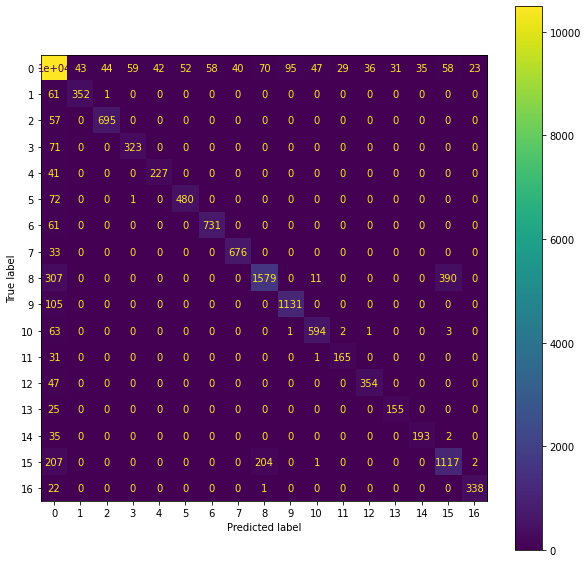

In [247]:
print(clf.score(X1_test, Y1_test))
print(classification_report(Y1_test, clf.predict(X1_test)))

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X1_test, Y1_test, ax=ax)
plt.show()

In [213]:
print(clf.score(X2, Y2))
print(classification_report(Y2, clf.predict(X2)))

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X2, Y2, ax=ax)
plt.show()

ValueError: X has 200 features, but StandardScaler is expecting 204 features as input.

(111104,)
(512, 217)


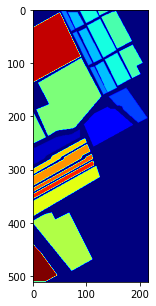

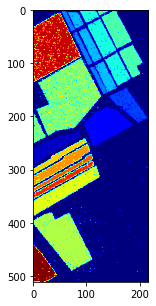

In [248]:
y1_predict = clf.predict(X1)
print(y1_predict.shape)

y1_predict_reshaped = y1_predict.reshape((salinas_gt.shape))
print(y1_predict_reshaped.shape)

plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(y1_predict_reshaped, cmap='jet')
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56975
           1       0.96      1.00      0.98      2009
           2       0.98      1.00      0.99      3726
           3       0.98      0.99      0.99      1976
           4       0.88      0.99      0.93      1394
           5       0.97      0.99      0.98      2678
           6       0.96      1.00      0.98      3959
           7       0.97      1.00      0.98      3579
           8       0.99      0.99      0.99     11271
           9       0.99      1.00      0.99      6203
          10       0.95      1.00      0.98      3278
          11       0.92      0.99      0.96      1068
          12       0.96      1.00      0.98      1927
          13       0.87      0.99      0.93       916
          14       0.91      0.99      0.95      1070
          15       0.99      1.00      0.99      7268
          16       0.98      1.00      0.99      1807

    accuracy              

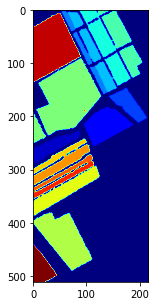

In [253]:
y1_pred_rc = closing(y1_predict_reshaped, morpho.diamond(1))
y1_pred_rc = opening(y1_pred_rc, morpho.diamond(1))
print(classification_report(Y1, y1_pred_rc.flatten()))
print(classification_report(Y1, y1_predict))

plt.figure(figsize=(5,5))
plt.imshow(y1_pred_rc, cmap='jet')
plt.show()

(21025,)
(145, 145)


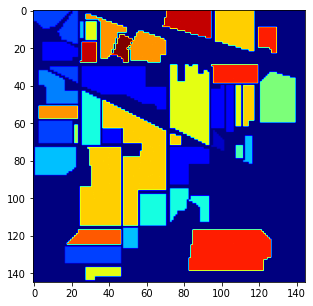

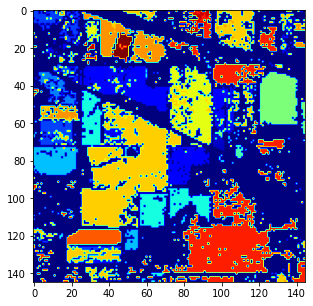

In [60]:
y2_predict = clf.predict(X2)
print(y2_predict.shape)

y2_predict_reshaped = y2_predict.reshape((indiana_pines_gt.shape))
print(y2_predict_reshaped.shape)

plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(y2_predict_reshaped, cmap='jet')
plt.show()

In [63]:
from skimage.morphology import opening, closing
from skimage import morphology as morpho

              precision    recall  f1-score   support

           0       0.81      0.87      0.84     10776
           1       0.86      0.93      0.90        46
           2       0.79      0.80      0.79      1428
           3       0.81      0.52      0.63       830
           4       1.00      0.48      0.65       237
           5       0.92      0.75      0.83       483
           6       0.92      0.88      0.90       730
           7       1.00      0.57      0.73        28
           8       0.90      0.99      0.95       478
           9       0.00      0.00      0.00        20
          10       0.89      0.64      0.74       972
          11       0.81      0.77      0.79      2455
          12       0.89      0.76      0.82       593
          13       0.94      0.99      0.96       205
          14       0.61      0.89      0.72      1265
          15       1.00      0.10      0.18       386
          16       0.92      0.91      0.92        93

    accuracy              

/home/simon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/simon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/simon/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


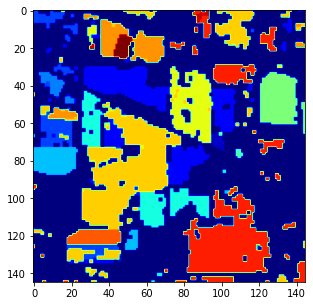

In [92]:
y2_pred_rc = opening(y2_predict_reshaped, morpho.square(2))
y2_pred_rc = closing(y2_pred_rc, morpho.square(2))
print(classification_report(Y2, y2_pred_rc.flatten()))

plt.figure(figsize=(5,5))
plt.imshow(y2_pred_rc, cmap='jet')
plt.show()